In [1]:
import json

import pandas as pd
import spacy

import time

import numpy as np

from collections import Counter, defaultdict
from itertools import chain
import re

import arrow 
import os

import googlemaps

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
import plotly.graph_objs as go

import cufflinks as cf

import scattertext as st
from scattertext import word_similarity_explorer

from gender import GenderDetector

In [2]:
nlp = spacy.load('en')

nlp.Defaults.stop_words |= {'probably', 'perhaps', 'really', 'definitely', 'bit'}
# STOPWORDS = nlp.Defaults.stop_words

In [3]:
init_notebook_mode(connected=True)

In [28]:
class T:
    
    def __init__(self, review_file, users_file, attract_file):
        
        """
        collected TripAdvisor data comes as JSONs; this class does some data processing including imputation
        """

        self.DIR = os.path.join('data', 'melbourne')
        
        self.r = json.load(open(os.path.join(self.DIR, review_file)))
        self.u = json.load(open(os.path.join(self.DIR, users_file)))
        self.a = json.load(open(os.path.join(self.DIR, attract_file))) 
        
        self.attribute_encodings = json.load(open('data/attribute_encodings.json')) 
        self.attribute_encodings_rev = defaultdict(lambda: defaultdict(str))
        
        self.countries = json.load(open('data/countries.json'))
        self.KEY_COUNTRIES = [line.lower().strip() for line in open('data/key_countries.txt').readlines() 
                                              if line.lower().strip()]
        
        for attr in self.attribute_encodings:
            self.attribute_encodings_rev[attr] = {s: i for i, s in self.attribute_encodings[attr].items()}
            
        
        
#         self.gmap s = googlemaps.Client(key=open('creds/geocoding_api.key').readline().strip())
#         self.gd = GenderDetector()
        
    
    def drop_unusable_reviews(self, subs=['text', 'attr_id']):
        
        self.r_df = self.r_df.dropna(subset=subs, how='any')
        
        return self
    
    def drop_unusable_users(self, subs=['name'], how='any'):
        
        self.u_df = self.u_df.dropna(subset=subs)
        
        return self
    
    def to_pandas(self):
        
        self.u_df = pd.DataFrame(self.u)
        self.r_df = pd.DataFrame(self.r)
        self.a_df = pd.DataFrame(self.a)
        
        return self
    
    def review_available_attributes(self):     
        
        self.genders = [_.lower() for _ in set(self.u_df['gender']) if str(_) and (str(_).lower() in 'm f'.split())]
        self.age_groups = sorted([ag for ag in set(self.u_df['age']) if '-' in str(ag)], 
                                               key=lambda x: int(str(x).split('-')[0]))
        
        self.tags = sorted(set(chain.from_iterable([t for t in self.u_df['tags'] if isinstance(t, list)])))
        
        print(f'available genders: {len(self.genders)}, age groups: {len(self.age_groups)}, tourist types: {len(self.tags)}')
        
        return self
    
    
    def show_stats(self):
        
        self.stats = defaultdict()
        
        self.stats['users'] = len(set(self.u_df['name']))
        self.stats['reviews'] = len(set(self.r_df['id']))
        self.stats['attractions'] = len(set(self.a_df['id']))
        
        self.stats['users_with_tags'] = len(set(self.u_df[self.u_df['tags'].apply(lambda _: isinstance(_, list) and len(_) > 0)]['name']))
        self.stats['users_with_gender'] = len(set(self.u_df[self.u_df['gender'].apply(lambda _: str(_) in 'm f'.split())]['name']))
        self.stats['users_with_age'] = len(set(self.u_df[self.u_df['age'].apply(lambda _: isinstance(_, str) and bool(re.search(r'\d+\-\d+', _)))]['name']))
        
        print(self.stats)
              
        return self
    
    def prepr_(self, review_text):
              
        """
        process a review text review_text provided as a string
        """
              
        if not review_text.strip():
              raise Exception('review with no text!')
              
        review_ = defaultdict(list)

        # create a doc from the original; this is needed to make sure the entities/labels are captured
        # as these are sensitive to lower/upper case
        doc = nlp(review_text)
        # store entities and labels     
        review_['ents'] = ' '.join([e.text for e in doc.ents]).strip()
        review_['labels'] = ' '.join([e.label_ for e in doc.ents]).strip()
         
        # now create a doc from the lowercased reviews
        doc = nlp(review_text.lower())
        
        review_['lemmatised'] = ' '.join([v for v in ['$' if w.is_currency else '' if w.is_stop else w.lemma_ for w in doc] if v.isalpha() and (len(v) > 1)]).strip()

        review_['nouns'] = ' '.join([w.lemma_ for w in doc if w.pos_ == 'NOUN']).strip()
        review_['verbs'] = ' '.join([w.lemma_ for w in doc if w.pos_ == 'VERB']).strip()
        
        return review_
    
    def add_processed_reviews(self):
        
        t0 = time.time()
        
        print(f'processing {len(self.r_df)} reviews..')
            
        dd = defaultdict()
        
        e_ = len(self.r_df)//10 
              
        for i, row in enumerate(self.r_df.iterrows(), 1):
              
            dd[row[1]['id']] = self.prepr_(row[1]['text'])
              
            if i%e_ == 0:
                print(f'#{i}/{len(self.r_df)} done..')
              
        self.r_df = self.r_df.join(pd.DataFrame.from_dict(dd, orient='index'), on='id', how='inner')
        
        print('elapsed time: ', time.time() - t0)
              
        return self
    
    def save_to_csv(self, what_lst):
        
        if 'reviews' in what_lst:   
            self.r_df.to_csv(os.path.join(self.DIR, 'reviews.csv'), index=False)
            
        if 'users' in what_lst:  
            
            _df = self.u_df
            
            _df['tags'] = self.u_df['tags'].apply(lambda x: '|'.join(x))
            
            _df.to_csv(os.path.join(self.DIR, 'users.csv'), index=False)
            
        if 'attractions' in what_lst:   
            self.a_df.to_csv(os.path.join(self.DIR, 'attractions.csv'), index=False)
                
        return self
    
    def read_from_csv(self):
        
        self.r_df = pd.read_csv(os.path.join(self.DIR, 'reviews.csv'))
        
        self.u_df = pd.read_csv(os.path.join(self.DIR, 'users.csv'))
        self.u_df['tags'] = self.u_df['tags'].str.split('|')
        
        self.a_df = pd.read_csv(os.path.join(self.DIR, 'attractions.csv'))
        
        return self
             
    def _tags_to_cols(self, tag_list):
        
        if not isinstance(tag_list, list):
            return [None]*len(self.tags)
        
        return ['yes' if tag in tag_list else 'no' for tag in self.tags]
    
    def tags_to_cols(self):
        
        self.u_df = pd.concat([self.u_df, 
                            pd.DataFrame(self.u_df['tags'].apply(self._tags_to_cols).to_list(), 
                                         columns=self.tags)], axis=1).drop('tags', axis=1)
        
        return self

              
    def _fix_location(self, s):
              
        """
        using Google Geocoding API to clarify users location
        """
        
        loc = dict()
        
        if not (isinstance(s, str) and s.strip()):
            print('geocoding API needs a string argument!')
            return loc
        
        geocode_result = self.gmaps.geocode(s)
        
        # take only the top result
        if geocode_result:
            res = geocode_result[0]
        else:
            print(f'geocoding api can\'t find this location: {s}!')
            return loc
        
        if 'address_components' in res:
            for _ in res['address_components']:
                if 'country' in _['types']:
                    loc.update({'country': _['long_name']})
                if 'locality' in _['types']:
                    loc.update({'locality': _['long_name']})
        if 'formatted_address' in res:
            loc.update({'location': res['formatted_address']})
        
        try:
            loc.update({'coordinates': res['geometry']['location']})
        except:
            pass
        
        if not loc:
            print('locationd fields couldn\'t be retrieved from geocoding result!')
                               
        return loc

    
    def impute_location(self):
        
        print('imputing country...', end=' ')
              
        t0 = time.time()
              
        localities = []
        countries = []
    
        c_geo = 0
              
        in_str = lambda s1, s2: ' ' + s1 + ' ' in ' ' + s2 + ' '
        
        for i, row in enumerate(self.u_df.iterrows(), 1):
                               
            users_country = None
              
            if isinstance(row[1].location, str):
              
                loc_str = ' '.join(re.sub(r'[\-\_]', ' ', row[1].location).split()).lower()

                _found_countries = set()

                for country in self.countries:
              
                    if in_str(country['name'].lower(), loc_str):
                        _found_countries.add(country['name'].lower())
              
                    alt_names = country.get('other_names', None)
              
                    if alt_names:
                          for alt_name in alt_names:
                              if in_str(alt_name, loc_str):
                                  _found_countries.add(alt_name.lower())

                if len(_found_countries) == 1:
                    users_country = _found_countries.pop()
                else:
#                   # run geolocation
#                   r = self._fix_location(loc_str)
#                   c_geo += 1
              
#                   if 'country' in r:
#                      users_country = r['country'].lower()
              
                  users_country = None
            
#             print(f'#{i}: location: {row[1].location} -> country: {users_country}')
            
            countries.append(users_country)
                               
        self.u_df['country'] = [c if (not c) or (c in self.KEY_COUNTRIES) else 'other' for c in countries]
        
        m, s = divmod(time.time() - t0, 60)
              
        print(f'done. elapsed time: {m:.0f}:{s:.0f}')
              
#         print(f'ran geolocation {c_geo} times ({100*c_geo/len(self.u_df):.1f}%)')
        
        return self
    
    def _impute_gender(self, s):
        
        if not isinstance(s, str):
              return None
              
        # separate nicknames like TrevorJ into trevor J; or Mike23 into Mike 23
        s = re.sub(r'([a-z]{1})([A-Z0-9]+)', r'\1 \2', s)
        
        return self.gd.gender(s)
    
    def impute_gender(self):
        
        print('imputing gender...', end=' ')
              
        t0 = time.time()
        
        avail_msk = self.u_df['gender'].str.lower().isin(self.genders)
        
        tot_users = len(set(self.u_df['name']))
              
        g_avail_bf = len(set(self.u_df[avail_msk]['name']))
        
        av = self.u_df[avail_msk]
        nav = self.u_df[~avail_msk]
        
        nav['gender'] = nav['name'].apply(self._impute_gender)
              
        self.u_df = pd.concat([av, nav])
              
        m, s = divmod(time.time() - t0, 60)
              
        print(f'done. elapsed time: {m:.0f}:{s:.0f}')
              
        g_avail_af = len(set(self.u_df[self.u_df['gender'].str.lower().isin(self.genders)]['name']))
              
        print(f'availability +{100*g_avail_af/g_avail_bf - 100:.1f}%: now {g_avail_af:,} users ({100*g_avail_af/tot_users:.1f}%) was {g_avail_bf:,} ({100*g_avail_bf/tot_users:.1f}%)')
              
        return self
    
    def merge_data(self):
        
        self.data = self.r_df.join(self.u_df.set_index('name'), on='by_user', how='inner')
        
        self.data.to_csv(os.path.join(self.DIR, 'data.csv'))
        
        return self
    
    def selector(self, req_dict, data_from_csv=True):

        """
        return a data frame obtained from the original one (df) by filtering out all rows that don't match
        the required values provided in the dictionary req_dict which looks like, for example, 
        {'age': '13-17', 'gender': 'f',...}

        what if after all the filtering all that's left is an empty data frame? then just return None
        """
        if data_from_csv:
            out = pd.read_csv(os.path.join(self.DIR, 'data.csv'))
        else:
            out = self.data
        
        if self.data.empty:
            print('dataframe you\'re trying to select from is empty!')
            return None

        actual_cols = set(self.data.columns) | {'tag'} 
        required_cols = set(req_dict)

        if not (required_cols <= actual_cols):
            cols_na = ', '.join(required_cols - actual_cols)
            print(f'column(s) {cols_na} you\'re asking for are not available!')
            return None

        for col in required_cols:

            if req_dict[col] != 'all':  # i.e. in {'age': '13-17'..} age value is '13-17' and not "all"

                if col != 'tag':  
                    # except for tags, we simply compare the actual vs required column values
                    out = out[out[col].astype(str) == req_dict[col]]
                else:
                    # then it's a tag, e.g. {"tag": "foodie"}, we search where it's "yes" in the "foodie" column
                    out = out[out[req_dict[col]] == 'yes']
                if out.empty:
                    break
        
        if out.empty:
            return None
        else:
            return out
              
              
    def select_reviews_for_segments(self, seg1_dict, seg2_dict, min_frq=5):
        
        t0 = time.time()
        
        eligible = []
        seg_dfs = []
              
        for i, s in enumerate([seg1_dict, seg2_dict], 1):
            
            s_df = self.selector(s)
            
            if not isinstance(s_df, pd.DataFrame):
                eligible.append(False)
                break
            
            # what if selected not None but a data frame but there's not enough reviews?
              
            if len(set(s_df['by_user'])) < 50:
                eligible.append(False)   
            else:
                eligible.append(True)
                seg_dfs.append(s_df)
        
        
        if not all(eligible):
            return None
        else:
            
            k1 = seg_dfs[0]
            k1['segment'] = 'seg1'
            k2 = seg_dfs[1]
            k2['segment'] = 'seg2'
            
            kk = pd.concat([k1, k2])
            
                
        return kk
    
    def _minmax(self, ser):
        
        mn_, mx_ = ser.min(), ser.max()
        
        return (ser - mn_)/(mx_ - mn_)
    
    def seg_filename(self, seg1_dict, seg2_dict):
        
        fn_ = ['tdf']
        
        for i, sdik in enumerate([seg1_dict, seg2_dict], 1):
              
            fn_.append('-seg' + str(i) + '-')  # so now ['tdf', '-seg1-']
            
            for attr in 'age gender tag country'.split():
                    
                fn_.append(attr[0]) # so now ['textdf', 'seg1', 'a']
                # self.attribute_encodings_rev is like 'age': {'13-17': '1'},..
                fn_.append(self.attribute_encodings_rev[attr] \
                           .get(sdik.get(attr, 'all'), 'all'))  # ['textdf', '-seg1-', 'a', '2']
        
        fn = os.path.join('data', ''.join(fn_) + '.csv') 
        
        return fn
    
    def name_from_keys(self, dict_):
        
        return '/'.join(sorted([k.lower() + ':' + v for k, v in dict_.items()]))
    
    def analyse_reviews_for_segments(self, df, seg1_dict, seg2_dict, min_frq=5):
        
        print(f'building corpus for segments {self.name_from_keys(seg1_dict)} and {self.name_from_keys(seg2_dict)}...')
        
        t0 = time.time()
        
        corpus = st.CorpusFromPandas(df, 
                                     category_col='segment', 
                                     text_col='lemmatised', 
                                     nlp=nlp).build()
              
        self.freq_data = corpus.get_term_freq_df().rename(columns={'seg1 freq': 'seg1_frq', 'seg2 freq': 'seg2_frq'})
        
        self.freq_data['s1_score'] = corpus.get_scaled_f_scores('seg1')
        self.freq_data['s2_score'] = corpus.get_scaled_f_scores('seg2')
              
        # impose min frequency
        self.freq_data = self.freq_data[(self.freq_data['seg1_frq'] >= min_frq) & (self.freq_data['seg2_frq'] >= min_frq)]
        print(f'{len(self.freq_data):,} words occur at least {min_frq} times')
        
        sc = np.vectorize(lambda s1, s2: 2*(-0.5+(s1 if s1>s2 else 1-s2 if s2>s1 else 0)))
              
        self.freq_data['nfsc'] = sc(self.freq_data['s1_score'], self.freq_data['s2_score'])
              
        # scale frequencies
              
        self.freq_data['seg1_frq_sc'] = self._minmax(self.freq_data['seg1_frq'])
        self.freq_data['seg2_frq_sc'] = self._minmax(self.freq_data['seg2_frq'])
              
        # filename to save as .csv
        
        fn = self.seg_filename(seg1_dict, seg2_dict)

        self.freq_data.to_csv(fn)
              
        m, s = divmod(time.time() - t0, 60)
              
        print(f'saved to {fn}. elapsed time: {m:.0f}:{s:.0f}')
        
        return self              
    
    def generate_text_dfs(self):
        
        genders_q = defaultdict()
        genders_q['all'] = len(self.data)
        for g, c in Counter(self.data['gender']).items():
            if g in self.genders:
                genders_q[g] = c
                
        ags_q = defaultdict()
        ags_q['all'] = len(self.data)
        for ag, c in Counter(self.data['age']).items():
            if ag in self.age_groups:
                ags_q[ag] = c
        
        tags_q = defaultdict()
        tags_q['all'] = len(self.data)
        for t in self.tags:
            for yes_no, c in Counter(self.data[t]).items():
                if (yes_no == 'yes'):
                    tags_q[t] = c
                       
        genders_ext = [g for g, c in genders_q.items() if c >= 50]
        age_groups_ext = [ag for ag, c in ags_q.items() if c >= 50]
        tags_ext = [g for g, c in tags_q.items() if c >= 50]
        
        cmbs = len(genders_ext)*len(age_groups_ext)*len(tags_ext)
        
        print(f'total attribute combinations: {cmbs}')
        
        s1s = [{'age': ag, 'gender': g, 'tag': tt} for g in genders_ext
                                                   for ag in age_groups_ext
                                                   for tt in tags_ext]
        s2s = [{'age': ag, 'gender': g, 'tag': tt} for g in genders_ext
                                                   for ag in age_groups_ext 
                                                   for tt in tags_ext]
        
        av = 0
        nav = 0   
        
        for s1 in s1s:
            for s2 in s2s:
                if s1 != s2:
                    d = self.select_reviews_for_segments(s1, s2, min_frq=5)
                    if isinstance(d, pd.DataFrame):
                        self.analyse_reviews_for_segments(d, s1, s2, min_frq=5)
                        av += 1
                    else:
                        nav += 1
                        
        print(f'created data files for {av} segment pairs; skipped {nav} pairs due to insufficient data')
              
        return self
    
    def pipeline(self, preprocess=True, merge=True):
        
        if preprocess:
            
            """
            pre-processing stage is when the JSON files end up as locally saved CSVs with the spaCy produced
            columns; 
            """
            
            print('pre-processing json files...')
            self.to_pandas()
            self.drop_unusable_reviews()
            self.drop_unusable_users()
            self.show_stats()
            self.add_processed_reviews()
            self.save_to_csv(['reviews', 'attractions', 'users'])
            
        else:
            
            print('skipped pre-processing')
            
            self.read_from_csv()
            
        self.review_available_attributes()
        self.tags_to_cols()
        self.merge_data()
        self.generate_text_dfs()

In [ ]:
if __name__ == '__main__':
    
    t = T(review_file='revs.json',
             users_file='usrs.json',
             attract_file='attractions_melbourne.json') \
            .pipeline(preprocess=False)

skipped pre-processing
available genders: 2, age groups: 5, tourist types: 19
total attribute combinations: 300
building corpus for segments age:all/gender:all/tag:all and age:all/gender:all/tag:60+ traveller...
1,253 words occur at least 5 times
saved to data/tdf-seg1-a0g0t0c0-seg2-a0g0t1c0.csv. elapsed time: 4:24
building corpus for segments age:all/gender:all/tag:all and age:all/gender:all/tag:art and architecture lover...
2,348 words occur at least 5 times
saved to data/tdf-seg1-a0g0t0c0-seg2-a0g0t2c0.csv. elapsed time: 4:30
building corpus for segments age:all/gender:all/tag:all and age:all/gender:all/tag:backpacker...
233 words occur at least 5 times
saved to data/tdf-seg1-a0g0t0c0-seg2-a0g0t3c0.csv. elapsed time: 4:11
building corpus for segments age:all/gender:all/tag:all and age:all/gender:all/tag:beach goer...
785 words occur at least 5 times
saved to data/tdf-seg1-a0g0t0c0-seg2-a0g0t4c0.csv. elapsed time: 4:10
building corpus for segments age:all/gender:all/tag:all and age:a

In [5]:
TAKE = 300

df = pd.read_csv('data/tdf-seg1-a0g0t0c0-seg2-a0g0t5c0.csv')

s1_tb, s1_tu = df['seg1_frq_sc'].quantile(q=[0.20, 0.95])
s2_tb, s2_tu = df['seg2_frq_sc'].quantile(q=[0.20, 0.95])

df = df[((df['seg1_frq_sc'] < s1_tu) & (df['seg1_frq_sc'] > s1_tb)) & 
        ((df['seg2_frq_sc'] < s2_tu) & (df['seg2_frq_sc'] > s2_tb))].iloc[:TAKE]

colorscale=[[0, 'orange'], [1, '#2C72EC']]

layout= go.Layout(
#     title= 'Characteristic Words',
    hovermode= 'closest',
    xaxis= dict(
        title='Frequency in Reviews by Seg 1',
        ticklen= 5,
        tickmode='array',
        tickvals=np.linspace(df['seg1_frq_sc'].min(), df['seg1_frq_sc'].max(), num=5),
        ticktext=['low', '', 'medium', '', 'high'],
        zeroline= False,
        gridwidth= 2,
        showticklabels=True,
        showgrid=True,
    ),
    yaxis=dict(
        ticklen= 5,
        tickmode='array',
        tickvals=np.linspace(df['seg2_frq_sc'].min(), df['seg2_frq_sc'].max(), num=5),
        ticktext=['low', '', 'medium', '', 'high'],
        gridwidth= 2,
        zeroline=False,
        showticklabels=True,
        showgrid=True,
        tickangle=-90,
        title='Frequency in Reviews by Seg 2',
    ),
    legend=dict(orientation="h", x=0.5, y=1.1, yanchor="top"),
    annotations=[dict(text='Stronger Association with ', x=0.41, y=1.08, 
            showarrow=False, 
            xref="paper",
            yref="paper",
            yanchor="top"
                     )],
    showlegend= True
)

df_neg = df[df['nfsc']<0]
df_pos = df[df['nfsc']>0]

trace0 = go.Scatter(
    name='Seg1',
    x = df_neg['seg1_frq_sc'],
    y = df_neg['seg2_frq_sc'],
    mode = 'markers',
    hoverinfo='text', 
    marker=dict(
                color='orange', 
                size=10,
                opacity=0.85,
               ),
    text= df_neg.term)

trace1 = go.Scatter(
    name='Seg2',
    x = df_pos['seg1_frq_sc'],
    y = df_pos['seg2_frq_sc'],
    mode = 'markers',
    hoverinfo='text', 
    marker=dict(
                color='#2C72EC', 
                size=10, 
                opacity=0.85,
               ),
    text= df_pos.term)


fig= go.Figure(data=[trace0, trace1], layout=layout)

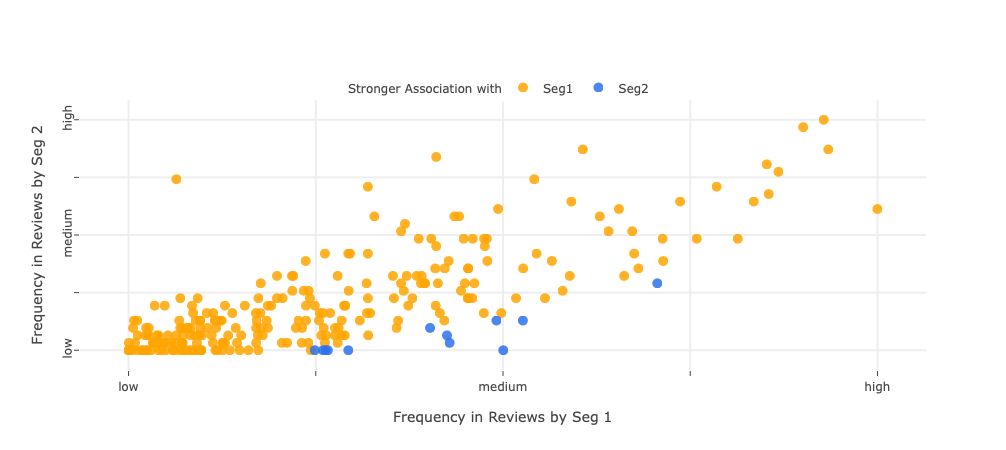

In [6]:
iplot(fig)

In [37]:
import random
trace2 = go.Scatter(
    name='Seg2',
    x = random.choices(np.linspace(0,1), k=len(df_pos['term'])),
    y = df_pos['seg2_frq_sc'],
    mode = 'text',
    hoverinfo='text', 
    marker=dict(
                color='#2C72EC', 
                size=10, 
                opacity=0.85
               ),
    textfont={'size': df_pos['seg1_frq']/df_pos['seg1_frq'].max()*40,
                           'color': 'orange'},
    text= df_pos.term)

In [38]:
fig2= go.Figure(data=[trace2])

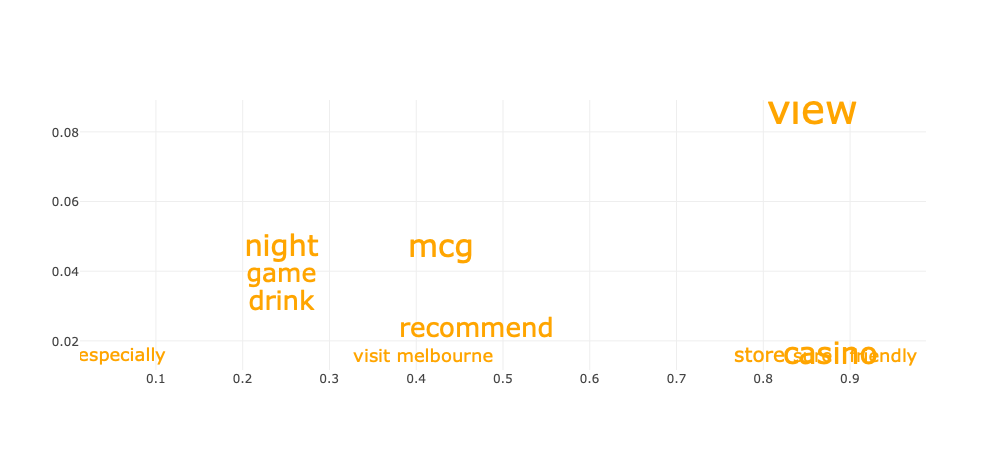

In [39]:
iplot(fig2)